# Electric Vehicle Charging Scheduling Problem

  This problem adresses the charging scheduling of 5 Electric Vehicles (EVs) in a Parking Lot (PL). It is assumed a time horizon of 24 hours, with 5 minutes resolution, totalling 288 points in a day. 
  
### 1. Parking Lot Block:  
  Initially, the main block model a PL with EV chargers. This modelling is based in two indexed sets: 'time' and 'ev'. Each variable calculated during the optimization will be indexed by these sets. It means that at each timestep, and for each EV, the problem needs to calculate some parameters and variables.

    'time' = (0,288) -> Time horizon
    'ev'   = (0,5)   -> 5 EVs
  
#### 1.1. PL Variables:
  Two variables will be defined by optimization:
    1. Power bought from the grid (Pc_grid[t]) - The amount of power (kW) requested from the grid at aeach timestep [t];
    2. Charging rate of each EV charging (C[n,t]) - Charging rate (kW) provided for each EV [n] at each timestep [t].
    
  Thus, is necessary to model the EVs, with battery characteristics and users' preferences, and tariff signals, based on Time of Use tariff prices. This way, the Parking Lot main block needs to import two other blocks and a data file: 
    1. EV () - for electric vehicles constraints modelling;
    2. Tariff () - for tariff constraint modelling;
    3. data (for data input).
    


In [ ]:
from pyomo.environ import *

m = AbstractModel()
m.time    = Set(initialize=(0,288))
m.ev      = Set(initialize=(0,5))

m.Pc_grid = Var(m.time,       within=PositiveReals)   # Power bought from grid (defined by optimization) for each timestep
m.C       = Var(m.ev, m.time, bounds=(0,1))           # Charging rate (Decision variable) with respect to 'time' and 'ev' -> C[n,t]

from EVs import EV
m.EV = EV()                 # EV Class

from Tariff import tariff
m.tariff = tariff()         # Tariff Class 

#### 1.2. PL Global Constraints:
Two global constraints are defined to guarantee the PL power balance and impose power limitations for the distribution transformer. For the latter, is considered a limitation of two EV simultaneously charging, since 5 EVs are adopted for simplification purposes.

    Pmax_grid = 11.10 kW -> Defined in data file (data.py)

In [ ]:
@m.Constraint(m.time)
def transformer(m, t):
    return (Pc_grid[t] <= Pmax_grid for t in m.time)

@m.Constraint(m.time)
def power_balance(m, t):
    return sum((m.C[n,t]*m.Pmax[n] for n in m.ev) == Pc_grid[t] for t in m.time)

#### 1.3. Objective Function:

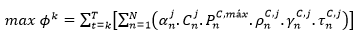

The objective function aims to maximize the carging rate (C[n,t]) of each EV "n" at each timestep "t", considering a few coefficients:
    1. a[n,t]:   Binary variable - indicates the status of each EV (1 if it is connected; 0 otherwise);
    2. C[n,t]:   Decision variable - charging rate of each EV "n" at each timestep "t";
    3. Pmax[n]:  Maximum EV power - from data input for each EV "n"
    4. roC[n,t]: Charging priority index - calculated via Constraint declaration on EV Block;
    5. yC[n,t]:  Battery degradation priority index - calculated via Constraint declaration on EV Block;
    6. tC[t]:    Tariff priority index - calculated via Constraint declaration on Tariff Block;
    


In [ ]:
def obj_rule (m, n, t):
    return sum(m.a[n,t]*m.C[n,t]*m.Pmax[n]*m.yC[n,t]*m.roC[n,t]*m.tC[t] for n in m.ev for t in m.time)
m.obj = Objective(rule=obj_rule, sense=maximize)

#### 1.4. Problem Instance
Create an instance of the problem 

In [ ]:
inst = m.create_instance(data.py)

#### 1.5. Problem Solving
To solve the problem

In [ ]:
opt = SolverFactory("clc")                 # See what solver to use

res = opt.solve(inst, load_solutions=True)